In [ ]:
import numpy as np
from urllib import request
import gzip
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Ref: https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e

# Load Mnist

In [ ]:
filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"].reshape(-1,28,28), mnist["training_labels"], mnist["test_images"].reshape(-1,28,28), mnist["test_labels"]
init()

Download complete.
Save complete.


# Load Data

In [ ]:
X_train,y_train,X_test,y_test = load()
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [ ]:
# Make Dataset
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y
    def __len__(self): # Return number of dataset
        return len(self.y)
    def __getitem__(self, idx):
       img = self.X[idx].reshape(1,28,28)/255
       return {'x': torch.FloatTensor(img), 'y': self.y[idx]}

train_dataset = ImageDataset(X_train,y_train)
test_dataset = ImageDataset(X_test,y_test)

batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)

In [ ]:
train_dataset

In [ ]:
for idx,batch in enumerate(train_loader):
  print("X Shape",batch['x'].shape)
  print("y Shape",batch['y'].shape) 
  break
#print("X Shape",batch['x'].shape)
#print("y Shape",batch['y'].shape)

X Shape torch.Size([64, 1, 28, 28])
y Shape torch.Size([64])


# Model Building

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x): # <-- Fix that it should have
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320) # <-- Flatten layer
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
!pip install torch-summary

In [ ]:
from torchsummary import summary

model = Net()
summary(model, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 24, 24]          260
├─Conv2d: 1-2                            [-1, 20, 8, 8]            5,020
├─Dropout2d: 1-3                         [-1, 20, 8, 8]            --
├─Linear: 1-4                            [-1, 50]                  16,050
├─Linear: 1-5                            [-1, 10]                  510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (M): 0.48
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.08
Estimated Total Size (MB): 0.14


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 24, 24]          260
├─Conv2d: 1-2                            [-1, 20, 8, 8]            5,020
├─Dropout2d: 1-3                         [-1, 20, 8, 8]            --
├─Linear: 1-4                            [-1, 50]                  16,050
├─Linear: 1-5                            [-1, 10]                  510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (M): 0.48
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.08
Estimated Total Size (MB): 0.14

# Training step

In [ ]:
# Initial
model = Net()
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss().to(device) # loss function

# Training Step
model.train()
for idx,batch in enumerate(train_loader):
  optimizer.zero_grad() # <-- important

  batch_X = batch['x'].to(device)
  label = batch['y'].to(device)

  logit = model(batch_X)
  loss = criterion(logit,label)
  
  loss.backward()
  optimizer.step()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
# Save Weight
torch.save({"state_dict":model.state_dict()}, "checkpoint.pth")

# Load Model From Weight

In [ ]:
model = Net()
model.to(device)

model_chpt = torch.load("checkpoint.pth")
model.load_state_dict(model_chpt['state_dict'])

<All keys matched successfully>

# Inference Model

In [ ]:
class InferenceImageDataset(torch.utils.data.Dataset):
    def __init__(self,X):
        self.X = X
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
       img = self.X[idx].reshape(1,28,28)/255
       return {'x': torch.FloatTensor(img)}

test_dataset = InferenceImageDataset(X_test)

batch_size = 64
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)

In [ ]:
model.eval()

pred = []
for idx,batch in enumerate(train_loader):
  batch_X = batch['x'].to(device)
  with torch.no_grad():
    logits = model(batch_X)
    pred+=logits.argmax(axis=1).cpu().numpy().tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
len(pred)

60000

# Workshop
* Pokemon Classification Workshop: https://www.kaggle.com/vishalsubbiah/pokemon-images-and-types

In [ ]:
!gdown --id 1hEXrxhHkTRE3NNGZgWbUnaGlajPgTTqr

Downloading...
From: https://drive.google.com/uc?id=1hEXrxhHkTRE3NNGZgWbUnaGlajPgTTqr
To: /content/pokemon.zip
100% 2.59M/2.59M [00:00<00:00, 168MB/s]


In [ ]:
!unzip -qq pokemon.zip

replace pokemon_.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import pandas as pd

df = pd.read_csv('pokemon_.csv')

In [ ]:
class_name = df.Type1.unique()
class_name = list(class_name)

In [ ]:
(df['Type1'])[1]

'Grass'

In [ ]:
for idx, batch in enumerate(df['Type1']):
  if batch in class_name :
     (df['Type1'])[idx] = class_name.index(batch)
     


In [ ]:
df

,Name,Type1,Type2
0,bulbasaur,0,Poison
1,ivysaur,0,Poison
2,venusaur,0,Poison
3,charmander,1,NaN
4,charmeleon,1,NaN
...,...,...,...
804,stakataka,11,Steel
805,blacephalon,1,Ghost
806,zeraora,6,NaN
807,meltan,16,NaN


In [ ]:
image_path = ('/content/pokemon_images')

In [ ]:
df_type1 = df.groupby('Type1')['Name'].nunique()
print(df_type1)

In [ ]:
import cv2 as cv

In [ ]:
list(df['Name'])[0]

'bulbasaur'

In [ ]:
(df['Name'])[0]

'bulbasaur'

In [ ]:
import os
list = os.listdir('/content/pokemon_images')
list

In [ ]:
list = os.listdir('/content/pokemon_images')
type(list)

list

In [ ]:
df

,Name,Type1,Type2
0,bulbasaur,0,Poison
1,ivysaur,0,Poison
2,venusaur,0,Poison
3,charmander,1,NaN
4,charmeleon,1,NaN
...,...,...,...
804,stakataka,11,Steel
805,blacephalon,1,Ghost
806,zeraora,6,NaN
807,meltan,16,NaN


In [ ]:
import os

filename = os.listdir('/content/pokemon_images')

namelist = {}

for name in filename :
  Newname, filetype = name.split(".")
  namelist[Newname] = name
  


In [ ]:
namelist

In [ ]:
df['newName']= df['Name'].apply(lambda x : namelist[x])

In [ ]:
list(df['newName'])

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self,df):
        self.X = list(df['newName'])
        self.Y = list(df['Type1'])
    def __len__(self): # Return number of dataset
        return len(self.Y)
    def __getitem__(self, idx):
       X_img = cv.imread('/content/pokemon_images/' + self.X[idx])
       img = cv.cvtColor(X_img, cv.COLOR_BGR2GRAY)
       img = cv.resize(img, (28, 28)) / 255
       trainIm = np.expand_dims(img, axis=-1)

       return {'x': torch.FloatTensor(trainIm), 'y': self.Y[idx]}

In [ ]:
pokemon_train_dataset = ImageDataset(df)
#pokemon_test_dataset = ImageDataset(X_test,y_test)

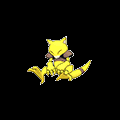

(28, 28, 3)


In [ ]:
from google.colab.patches import cv2_imshow
im = cv.imread('/content/pokemon_images/' + 'abra.png')
cv2_imshow(im)

img = cv.resize(im, (28, 28)) / 255
print(img.shape)

In [ ]:
batch_size = 64
train_loader_pokemon = torch.utils.data.DataLoader(dataset=pokemon_train_dataset, batch_size=batch_size)

In [ ]:
for idx,batch in enumerate(train_loader_pokemon):
  print("X Shape",(batch['x']).swapaxes(1,3).shape)
  print("y Shape",batch['y'].shape) 
  break
#print("X Shape",batch['x'].shape)
#print("y Shape",batch['y'].shape)

X Shape torch.Size([64, 1, 28, 28])
y Shape torch.Size([64])


In [ ]:
#--> resize([64, 1, 28, 28])

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 18)

    def forward(self, x): # <-- Fix that it should have
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320) # <-- Flatten layer
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 18),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
# Initial
model = Net()
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss().to(device) # loss function

# Training Step
model.train()
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=18, bias=True)
)


In [ ]:
for idx,batch in enumerate(train_loader_pokemon):
  
print(i)
optimizer.zero_grad() # <-- important

train_data = batch['x'].swapaxes(1, 3)
batch_X = train_data.to(device)
label = batch['y'].to(device)

logit = model(batch_X)
loss = criterion(logit,label)

loss.backward()
optimizer.step()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9


In [ ]:
# Save Weight
torch.save({"state_dict":model.state_dict()}, "checkpoint.pth")

In [ ]:
model = Net()
model.to(device)

model_chpt = torch.load("checkpoint.pth")
model.load_state_dict(model_chpt['state_dict'])

<All keys matched successfully>

In [ ]:
model.eval()

pred = []
for idx,batch in enumerate(train_loader_pokemon):
  batch_X = (batch['x'].swapaxes(1, 3)).to(device)
  with torch.no_grad():
    logits = model(batch_X)
    pred+=logits.argmax(axis=1).cpu().numpy().tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
pred[0]

16

In [ ]:
len(pred)

809